# Introduction
The goals / steps of this project are the following:
* Perform a HOG(Histogram of Oriented Gradients) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
* Implement a sliding-window techinique and use trained classifier to search for vehicles in images.
* Generation heat-map to create detected bound-box on vehicles and eliminate the false-positives in video.

In [1]:
%matplotlib inline
import numpy as np
import cv2
import os, time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from helper import *

# Data preparation

In [4]:
vehicle_path = "./dataset/OwnCollection/vehicles/"
nonvehicle_path = "./dataset/OwnCollection/non-vehicles/"

In [5]:
vehicle_list = get_dataset(vehicle_path)
nonvehicle_list = get_dataset(nonvehicle_path)

In [6]:
ran_idx = np.random.randint(0, len(vehicle_list))
test_img = mpimg.imread(vehicle_list[ran_idx])
test_gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7d70f47588>,
 <matplotlib.image.AxesImage at 0x7f7d6c6e7fd0>)

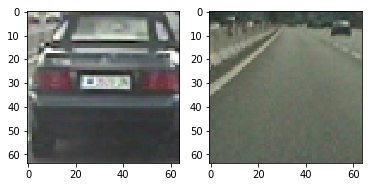

In [7]:
plt.subplot(121),plt.imshow(test_img)
plt.subplot(122),plt.imshow(mpimg.imread(nonvehicle_list[ran_idx]))

# Feature extraction
## HOG (Histogram of Oriented Gradients)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


([<matplotlib.lines.Line2D at 0x7f7cf58f3ef0>], None)

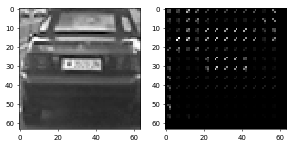

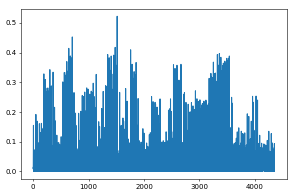

In [46]:
hog_features, hog_image = get_hog_features(test_gray, orient=9, pix_per_cell=5, cell_per_block=2, vis=True)

fig1 = plt.figure(dpi=50)
plt.subplot(121),plt.imshow(test_gray, cmap='gray')
plt.subplot(122),plt.imshow(hog_image, cmap='gray')
fig1.tight_layout()
fig2 = plt.figure(dpi=50)
plt.plot(hog_features, ),fig2.tight_layout()

## Binned color

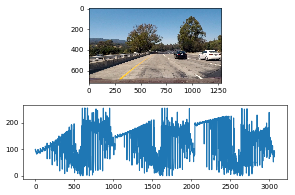

In [49]:
fig = plt.figure(dpi=50)
plt.subplot(211),plt.imshow(test_img)
plt.subplot(212),plt.plot(bin_spatial(test_img))
fig.tight_layout()

## Color histogram

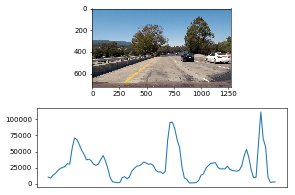

In [68]:
fig = plt.figure(dpi=50)
plt.subplot(211), plt.imshow(test_img)
plt.subplot(212), plt.plot(color_hist(test_img)),plt.xticks([])
fig.tight_layout()

## Parameter choiced

In [11]:
# Parameter choised
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [12]:
# Extract features from cars and non-cars
car_features = extract_features(vehicle_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(nonvehicle_list, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [13]:
# Dataset preprocessing, Normalization
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=ran_idx)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7cf4f365f8>,
 ([], <a list of 0 Text xticklabel objects>))

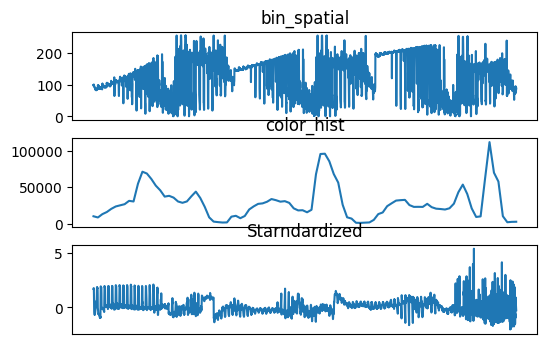

In [69]:
fig = plt.figure(dpi=100)
plt.subplot(311),plt.plot(bin_spatial(test_img)),plt.title('bin_spatial'),plt.xticks([])
plt.subplot(312),plt.plot(color_hist(test_img)),plt.title('color_hist'),plt.xticks([])
plt.subplot(313),plt.plot(X_train[ran_idx]),plt.title('Starndardized'),plt.xticks([])


# Classifier

In [16]:
svc = LinearSVC()

t=time.time()
svc.fit(X_train, y_train)
t2=time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


5.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9768


In [17]:
print(svc)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


# window search

In [18]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## hog_subsample

In [19]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1,-1)#.ravel()
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(hog_features).reshape(1,-1)
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = [(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)]
                cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6)                
                bbox.append(box)
    return bbox, draw_img#, hog_features, spatial_features, hist_features

In [20]:
ystart = 400
ystop = 656
scale = 1.5

In [21]:
# find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
test_img = mpimg.imread('./test_images/test1.jpg')
testbbox, draw_img = find_cars(img=test_img,
                               ystart=ystart,
                               ystop=ystop,
                               scale=scale,
                               svc=svc,
                               X_scaler=X_scaler,
                               orient=orient,
                               pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block,
                               spatial_size=spatial_size,
                               hist_bins=hist_bins)

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [22]:
testbbox

[[(0, 496), (96, 592)],
 [(144, 448), (240, 544)],
 [(240, 448), (336, 544)],
 [(384, 400), (480, 496)],
 [(816, 400), (912, 496)],
 [(864, 400), (960, 496)]]

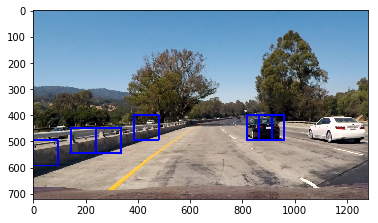

In [23]:
plt.imshow(draw_img)

In [32]:
def find_cars_multiple_scale(img, ystart, ystop, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    scales = [1.1,1.4, 1.8, 2.4, 2.9, 3.4]
    bbox_list = []
    bboxs = []           
    for scale in scales:
        #The first half of scales is valid for the upper half of image
        #box,draw_img, = find_cars(img, ystart,ystop,scale,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
        box, draw_img = find_cars(img=img,
                                   ystart=ystart,
                                   ystop=ystop,
                                   scale=scale,
                                   svc=svc,
                                   X_scaler=X_scaler,
                                   orient=orient,
                                   pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   spatial_size=spatial_size,
                                   hist_bins=hist_bins)
        bboxs.append(box)
        
    for i in range(len(bboxs)):
        for bbox in bboxs[i]:
            bbox_list.append(bbox)
            
    return bbox_list

In [34]:
out_bbox = find_cars_multiple_scale(test_img,ystart,ystop,svc,X_scaler,orient,pix_per_cell,cell_per_block,spatial_size,hist_bins)
len(out_bbox), out_bbox

/home/vmadmin/.local/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(28,
 [[(70, 435), (140, 505)],
  [(140, 505), (210, 575)],
  [(246, 470), (316, 540)],
  [(352, 540), (422, 610)],
  [(387, 505), (457, 575)],
  [(422, 505), (492, 575)],
  [(492, 400), (562, 470)],
  [(809, 400), (879, 470)],
  [(844, 400), (914, 470)],
  [(880, 400), (950, 470)],
  [(880, 435), (950, 505)],
  [(1056, 435), (1126, 505)],
  [(1126, 435), (1196, 505)],
  [(1161, 400), (1231, 470)],
  [(1161, 435), (1231, 505)],
  [(89, 489), (178, 578)],
  [(268, 444), (357, 533)],
  [(403, 400), (492, 489)],
  [(806, 400), (895, 489)],
  [(851, 400), (940, 489)],
  [(1120, 444), (1209, 533)],
  [(115, 457), (230, 572)],
  [(288, 400), (403, 515)],
  [(345, 400), (460, 515)],
  [(806, 400), (921, 515)],
  [(1036, 400), (1151, 515)],
  [(1094, 400), (1209, 515)],
  [(153, 400), (306, 553)]])

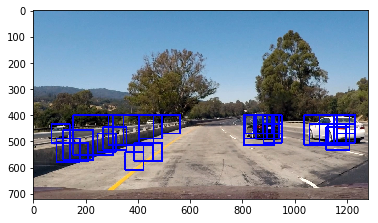

In [35]:
# Plot multi-scaled bounding-box
imcopy = np.copy(test_img)
for bbox in out_bbox:
        cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255),6)

plt.imshow(imcopy)

## Generate heat-map

In [97]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [98]:
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

heat = add_heat(heat, bbox_list=bbox_list)
heat = apply_threshold(heat,1)
heatmap = np.clip(heat, 0, 255)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

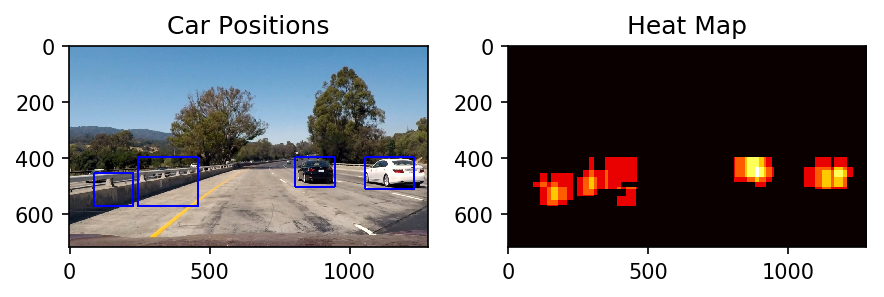

In [99]:
fig = plt.figure(dpi=150)
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Eliminate False Positives

# Video results

In [ ]:
# Combined all
def process_image(img):
    
    #find the bound-box
    bbox = find_cars()
    
    #find the heatmap
    draw_img = heatmap()
    

# Conclusion

# Reference
* Udacity SDC nanodegree P4 lesson scripts.
* https://chatbotslife.com/vehicle-detection-and-tracking-using-computer-vision-baea4df65906